In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch_geometric

torch_geometric.__version__


'2.1.0'

cuda:0


Extracting /tmp/COIL-DEL/COIL-DEL/COIL-DEL.zip
Processing...
Done!


COIL-DEL(3872)
length of set 3872
# of classes 100
Max size of adjacency matrix: 77 x 77
Initializing graph to image
total # of batches 121
108 training batches
13 test batches


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training data is 3456 long
epoch 0 :
Train Loss: 0.1612, Train Acc: 1.53
Val Loss: 0.1413, Val Acc: 3.37
epoch 1 :
Train Loss: 0.1407, Train Acc: 4.43
Val Loss: 0.1315, Val Acc: 7.45
epoch 2 :
Train Loss: 0.1311, Train Acc: 5.58
Val Loss: 0.1240, Val Acc: 6.25
epoch 3 :
Train Loss: 0.1236, Train Acc: 6.71
Val Loss: 0.1193, Val Acc: 7.21
epoch 4 :
Train Loss: 0.1199, Train Acc: 7.55
Val Loss: 0.1163, Val Acc: 7.21
1.7 minutes


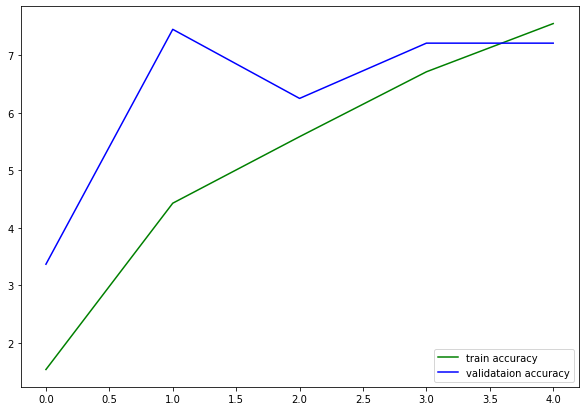

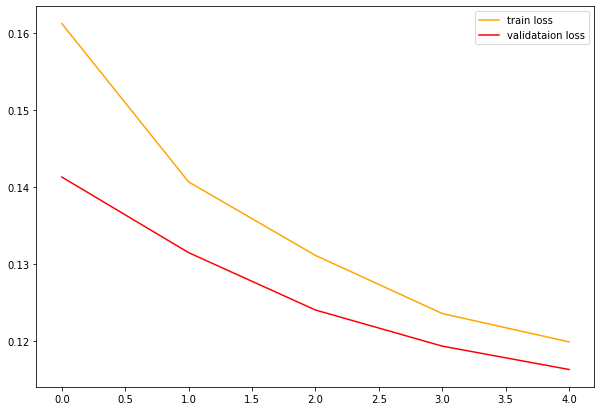

In [4]:
from re import I
from torch_geometric.data import Data 

from torch_geometric.datasets import TUDataset

import torchvision.transforms as transforms

import numpy as np
import torch
import torchvision
import torch.optim as optim
import time
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
import tensorflow as tf

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# training set improves but test set stays stable at >95% accuracy, (which is nice at least)
#dataset = TUDataset(root='/tmp/AIDS', name='AIDS')
#dataset = dataset.shuffle()

# frankenstein really seems to overfit
#dataset = TUDataset(root='/tmp/FRANKENSTEIN', name='FRANKENSTEIN')
#dataset = dataset.shuffle()

# enzymes works pretty well (much fewer examples, but 6 classes)
#dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
#dataset = dataset.shuffle()

# also shows real improvement, this one has 100 classes
dataset = TUDataset(root='/tmp/COIL-DEL', name='COIL-DEL')
dataset = dataset.shuffle()

# to divide evenly, make sure it's divisible by 32
dataset = dataset[(len(dataset) % 32):]

print(dataset)
print("length of set", len(dataset))
print("# of classes", dataset.num_classes)

max = 0
for data in dataset:
  if len(data.x) > max:
    max = len(data.x)
print("Max size of adjacency matrix:", max, "x", max)

print("Initializing graph to image")

# convert our graph data to "images" containing the adjacency matrix
batchlist = []
batch_targets = []
for k in range(int(len(dataset) / 32)):

  batch = np.zeros([32,3,224,224])
  targets = np.zeros([32])

  for j in range(32):

    index = j + (k * 32)
    graph = dataset[index]

    adj_matrix = np.zeros([3, 224, 224])

    num_nodes = len(graph.x)
    num_edges = len(graph.edge_index[0])
    offset = int((224 - num_nodes) / 2)

    # for each edge, initialize its entry in the adjaceny matrix as a colored pixel
    for i in range(num_edges):
      x = graph.edge_index[0][i]
      y = graph.edge_index[1][i]
      adj_matrix[0][offset + x][offset + y] = 1
      adj_matrix[1][offset + x][offset + y] = 1
      adj_matrix[2][offset + x][offset + y] = 1

    batch[j] = adj_matrix
    targets[j] = graph.y.item()

  # have to convert them to tensors so it actually works
  batch = torch.from_numpy(batch)
  batchlist.append(batch)
  targets = torch.from_numpy(targets)
  batch_targets.append(targets)

print("total # of batches", len(batchlist))

# splits it 90/10 train/test
cutoff = int(len(batchlist) * 0.9)
train_batches = batchlist[:cutoff]
test_batches = batchlist[cutoff:]
train_targets = batch_targets[:cutoff]
test_targets = batch_targets[cutoff:]
print(len(train_batches), "training batches")
print(len(test_batches), "test batches")

# now we get into the actual transfer learning!

vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
vgg16.classifier[6].out_features = dataset.num_classes

# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

# validation function
def validate(model, test_batches):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for i in range(len(test_batches)):

        # have to make them float for the output to work
        data = test_batches[i].to(device=device, dtype=torch.float)
        target = test_targets[i].to(device=device, dtype=torch.float)
        output = model(data)

        # have to make them ints for the loss to work
        target=target.to(torch.int64)

        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss / (len(test_batches) * 32)
    val_accuracy = 100. * val_running_correct / (len(test_batches) * 32)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

# training function
def fit(model, train_batches):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i in range(len(train_batches)):

        # have to make them floats for the output to work
        data = train_batches[i].to(device=device, dtype=torch.float)
        target = train_targets[i].to(device=device, dtype=torch.float)

        optimizer.zero_grad()
        output = model(data)
        
        # have to make them ints for the loss to work
        target=target.to(torch.int64)

        loss = criterion(output, target)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / (len(train_batches) * 32)
    train_accuracy = 100. * train_running_correct / (len(train_batches) * 32)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy
  
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

# train our chosen model
for epoch in range(5):
    print('epoch',epoch,":")
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, train_batches)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, test_batches)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print(round(((end-start)/60),1) , 'minutes')

# plot our accuracy and loss
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()